# LaTeX Formula Search and Index using Graphs

This notebook implements graph-based algorithms for indexing and searching LaTeX formulas. We'll represent formulas as abstract syntax trees (ASTs) and use graph algorithms for efficient search and similarity matching.

In [35]:
# Import required libraries
import re
import json
from collections import defaultdict, deque
from typing import Dict, List, Set, Tuple, Optional
import hashlib
from dataclasses import dataclass, field
import networkx as nx
import matplotlib.pyplot as plt

print("Libraries imported successfully")

Libraries imported successfully


## 1. LaTeX Formula Parser and AST Generator

First, we'll create a parser to convert LaTeX formulas into Abstract Syntax Trees (ASTs).

In [36]:
@dataclass
class FormulaNode:
    """Represents a node in the LaTeX formula AST"""
    node_type: str  # operator, function, variable, number, etc.
    value: str
    children: List['FormulaNode'] = field(default_factory=list)
    node_id: Optional[int] = None
    
    def __hash__(self):
        return hash((self.node_type, self.value))
    
    def __repr__(self):
        if self.children:
            return f"{self.node_type}({self.value})[{len(self.children)} children]"
        return f"{self.node_type}({self.value})"


class LaTeXParser:
    """Parse LaTeX formulas into AST representation"""
    
    def __init__(self):
        self.node_counter = 0
        # Define operator precedence
        self.operators = {
            '^': 3,  # superscript
            '_': 3,  # subscript
            '\\frac': 2,
            '\\sqrt': 2,
            '\\sum': 2,
            '\\int': 2,
            '\\prod': 2,
            '\\lim': 2,
            '*': 1,
            '/': 1,
            '+': 0,
            '-': 0,
            '=': -1,
        }
        
    def tokenize(self, latex: str) -> List[str]:
        """Tokenize LaTeX formula"""
        # Remove extra spaces
        latex = latex.strip()
        tokens = []
        i = 0
        
        while i < len(latex):
            # Skip whitespace
            if latex[i].isspace():
                i += 1
                continue
            
            # LaTeX command (starts with \)
            if latex[i] == '\\':
                j = i + 1
                while j < len(latex) and latex[j].isalpha():
                    j += 1
                tokens.append(latex[i:j])
                i = j
            # Braces
            elif latex[i] in '{}':
                tokens.append(latex[i])
                i += 1
            # Operators and special chars
            elif latex[i] in '^_=+-*/()[]':
                tokens.append(latex[i])
                i += 1
            # Numbers (including decimals)
            elif latex[i].isdigit() or latex[i] == '.':
                j = i
                while j < len(latex) and (latex[j].isdigit() or latex[j] == '.'):
                    j += 1
                tokens.append(latex[i:j])
                i = j
            # Variables and other characters
            else:
                tokens.append(latex[i])
                i += 1
                
        return tokens
    
    def parse(self, latex: str) -> FormulaNode:
        """Parse LaTeX formula into AST"""
        self.node_counter = 0
        tokens = self.tokenize(latex)
        
        if not tokens:
            return FormulaNode("empty", "", node_id=self._next_id())
        
        # Build AST
        root = self._parse_expression(tokens, 0)[0]
        return root
    
    def _next_id(self) -> int:
        self.node_counter += 1
        return self.node_counter
    
    def _parse_expression(self, tokens: List[str], pos: int) -> Tuple[FormulaNode, int]:
        """Parse expression recursively"""
        if pos >= len(tokens):
            return FormulaNode("empty", "", node_id=self._next_id()), pos
        
        # Handle grouped expressions
        if tokens[pos] == '{':
            return self._parse_group(tokens, pos)
        
        # Handle LaTeX commands
        if tokens[pos].startswith('\\'):
            return self._parse_command(tokens, pos)
        
        # Handle operators
        if tokens[pos] in ['^', '_']:
            return self._parse_script(tokens, pos)
        
        # Handle numbers, variables, operators
        node = FormulaNode(self._classify_token(tokens[pos]), tokens[pos], node_id=self._next_id())
        return node, pos + 1
    
    def _parse_group(self, tokens: List[str], pos: int) -> Tuple[FormulaNode, int]:
        """Parse grouped expression in braces"""
        if tokens[pos] != '{':
            return self._parse_expression(tokens, pos)
        
        pos += 1  # skip '{'
        children = []
        
        while pos < len(tokens) and tokens[pos] != '}':
            child, pos = self._parse_expression(tokens, pos)
            children.append(child)
        
        if pos < len(tokens):
            pos += 1  # skip '}'
        
        # Create group node
        if len(children) == 1:
            return children[0], pos
        
        group_node = FormulaNode("group", "", children=children, node_id=self._next_id())
        return group_node, pos
    
    def _parse_command(self, tokens: List[str], pos: int) -> Tuple[FormulaNode, int]:
        """Parse LaTeX command"""
        cmd = tokens[pos]
        pos += 1
        
        # Commands with arguments
        if cmd in ['\\frac', '\\binom']:
            # Need two arguments
            arg1, pos = self._parse_expression(tokens, pos)
            arg2, pos = self._parse_expression(tokens, pos)
            node = FormulaNode("function", cmd, children=[arg1, arg2], node_id=self._next_id())
            return node, pos
        
        elif cmd in ['\\sqrt', '\\sin', '\\cos', '\\tan', '\\log', '\\ln', '\\exp']:
            # One argument
            arg, pos = self._parse_expression(tokens, pos)
            node = FormulaNode("function", cmd, children=[arg], node_id=self._next_id())
            return node, pos
        
        elif cmd in ['\\sum', '\\int', '\\prod', '\\lim']:
            # Large operators, may have subscript/superscript
            node = FormulaNode("operator", cmd, node_id=self._next_id())
            return node, pos
        
        else:
            # Other commands (Greek letters, etc.)
            node = FormulaNode("symbol", cmd, node_id=self._next_id())
            return node, pos
    
    def _parse_script(self, tokens: List[str], pos: int) -> Tuple[FormulaNode, int]:
        """Parse superscript or subscript"""
        script_type = "superscript" if tokens[pos] == '^' else "subscript"
        pos += 1
        
        arg, pos = self._parse_expression(tokens, pos)
        node = FormulaNode(script_type, tokens[pos-1], children=[arg], node_id=self._next_id())
        return node, pos
    
    def _classify_token(self, token: str) -> str:
        """Classify token type"""
        if token in self.operators:
            return "operator"
        elif token.replace('.', '').isdigit():
            return "number"
        elif len(token) == 1 and token.isalpha():
            return "variable"
        else:
            return "symbol"


# Test the parser
parser = LaTeXParser()
test_formulas = [
    "x^2 + y^2 = r^2",
    "\\frac{a}{b} + c",
    "\\int x^2 dx",
    "\\sqrt{x + y}",
    "E = mc^2"
]

print("Testing LaTeX Parser:")
for formula in test_formulas:
    ast = parser.parse(formula)
    print(f"\nFormula: {formula}")
    print(f"AST Root: {ast}")

Testing LaTeX Parser:

Formula: x^2 + y^2 = r^2
AST Root: variable(x)

Formula: \frac{a}{b} + c
AST Root: function(\frac)[2 children]

Formula: \int x^2 dx
AST Root: operator(\int)

Formula: \sqrt{x + y}
AST Root: function(\sqrt)[1 children]

Formula: E = mc^2
AST Root: variable(E)


## 2. Graph Representation of Formulas

Convert AST to NetworkX graph for advanced operations.

In [37]:
class FormulaGraph:
    """Convert formula AST to graph representation"""
    
    def __init__(self, formula_node: FormulaNode):
        self.root = formula_node
        self.graph = nx.DiGraph()
        self._build_graph(formula_node)
        
    def _build_graph(self, node: FormulaNode, parent_id: Optional[int] = None):
        """Recursively build graph from AST"""
        node_label = f"{node.node_type}:{node.value}"
        self.graph.add_node(node.node_id, 
                           type=node.node_type, 
                           value=node.value,
                           label=node_label)
        
        if parent_id is not None:
            self.graph.add_edge(parent_id, node.node_id)
        
        for child in node.children:
            self._build_graph(child, node.node_id)
    
    def get_subgraph_hash(self, node_id: int, depth: int = 2) -> str:
        """Get hash of subgraph rooted at node_id up to certain depth"""
        subgraph_nodes = self._get_descendants(node_id, depth)
        subgraph = self.graph.subgraph(subgraph_nodes)
        
        # Create canonical string representation
        edges = sorted([(self.graph.nodes[u]['label'], self.graph.nodes[v]['label']) 
                       for u, v in subgraph.edges()])
        canonical = str(edges)
        
        return hashlib.md5(canonical.encode()).hexdigest()
    
    def _get_descendants(self, node_id: int, depth: int) -> Set[int]:
        """Get all descendants up to certain depth"""
        if depth == 0:
            return {node_id}
        
        descendants = {node_id}
        for child in self.graph.successors(node_id):
            descendants.update(self._get_descendants(child, depth - 1))
        
        return descendants
    
    def calculate_node_weights(self):
        """Calculate node weights based on importance metrics"""
        weights = {}
        
        # Type-based importance weights
        type_weights = {
            'operator': 3,
            'function': 4,
            'variable': 2,
            'number': 2,
            'symbol': 2,
            'superscript': 2,
            'subscript': 2,
            'group': 1,
            'empty': 1
        }
        
        for node in self.graph.nodes():
            node_data = self.graph.nodes[node]
            
            # Base weight from node type
            base_weight = type_weights.get(node_data['type'], 1)
            
            # Connectivity weight (how central the node is)
            degree_weight = self.graph.degree(node)
            
            # Structural importance (number of children)
            children_weight = self.graph.out_degree(node) * 0.5
            
            # Combined weight
            weights[node] = base_weight + degree_weight + children_weight
        
        return weights
    
    def calculate_edge_weights(self):
        """Calculate edge weights based on relationship importance"""
        edge_weights = {}
        
        # Relationship type weights
        relationship_weights = {
            'function_arg': 5,      # Function to argument
            'operator_operand': 4,  # Operator to operand
            'superscript': 3,       # Superscript relationship
            'subscript': 3,         # Subscript relationship
            'group_member': 2,      # Group membership
            'sequential': 1         # Sequential relationship
        }
        
        node_type_weights = {
            'operator': 3,
            'function': 4,
            'variable': 2,
            'number': 2,
            'symbol': 2,
            'superscript': 2,
            'subscript': 2,
            'group': 1,
            'empty': 1
        }
        
        for u, v in self.graph.edges():
            parent_data = self.graph.nodes[u]
            child_data = self.graph.nodes[v]
            
            # Determine relationship type
            if parent_data['type'] == 'function':
                rel_type = 'function_arg'
            elif parent_data['type'] == 'operator':
                rel_type = 'operator_operand'
            elif parent_data['type'] == 'superscript':
                rel_type = 'superscript'
            elif parent_data['type'] == 'subscript':
                rel_type = 'subscript'
            elif parent_data['type'] == 'group':
                rel_type = 'group_member'
            else:
                rel_type = 'sequential'
            
            # Base edge weight from relationship type
            base_weight = relationship_weights.get(rel_type, 1)
            
            # Add weight based on child node importance
            child_type_weight = node_type_weights.get(child_data['type'], 1)
            
            # Add weight based on subtree size (depth)
            subtree_size = len(list(nx.descendants(self.graph, v))) + 1
            subtree_weight = min(subtree_size * 0.5, 5)  # Cap at 5
            
            # Combined edge weight
            edge_weights[(u, v)] = base_weight + child_type_weight * 0.5 + subtree_weight * 0.3
        
        return edge_weights
    
    def visualize(self, figsize=(12, 8), show_weights=True, show_edge_weights=True):
        """Visualize the formula graph with optional node and edge weights"""
        pos = nx.spring_layout(self.graph, k=2, iterations=50)
        
        plt.figure(figsize=figsize)
        
        # Calculate weights
        node_weights = self.calculate_node_weights() if show_weights else None
        edge_weights = self.calculate_edge_weights() if show_edge_weights else None
        
        # Draw nodes with colors based on type
        node_colors = {
            'operator': 'lightblue',
            'function': 'lightgreen',
            'variable': 'lightyellow',
            'number': 'lightcoral',
            'symbol': 'lightpink',
            'superscript': 'lavender',
            'subscript': 'lavender',
            'group': 'lightgray'
        }
        
        if show_weights and node_weights:
            # Normalize weights for node sizes
            max_weight = max(node_weights.values()) if node_weights else 1
            min_weight = min(node_weights.values()) if node_weights else 1
            weight_range = max_weight - min_weight if max_weight > min_weight else 1
            
            for node_type in node_colors:
                nodes = [n for n, d in self.graph.nodes(data=True) if d['type'] == node_type]
                sizes = [500 + (node_weights[n] - min_weight) / weight_range * 2000 for n in nodes]
                nx.draw_networkx_nodes(self.graph, pos, nodelist=nodes, 
                                      node_color=node_colors.get(node_type, 'white'),
                                      node_size=sizes, alpha=0.8)
            
            # Draw edges with varying thickness and colors based on edge weights
            if show_edge_weights and edge_weights:
                # Normalize edge weights for visualization
                max_edge_weight = max(edge_weights.values()) if edge_weights else 1
                min_edge_weight = min(edge_weights.values()) if edge_weights else 1
                edge_weight_range = max_edge_weight - min_edge_weight if max_edge_weight > min_edge_weight else 1
                
                # Create edge lists by weight for color mapping
                edges_list = list(self.graph.edges())
                widths = [1 + (edge_weights[(u, v)] - min_edge_weight) / edge_weight_range * 4 
                         for u, v in edges_list]
                
                # Use colormap for edge weights
                edge_colors = [(edge_weights[(u, v)] - min_edge_weight) / edge_weight_range 
                              for u, v in edges_list]
                
                nx.draw_networkx_edges(self.graph, pos, edgelist=edges_list,
                                      edge_color=edge_colors, edge_cmap=plt.cm.Blues,
                                      arrows=True, arrowsize=20, width=widths, 
                                      alpha=0.7, edge_vmin=0, edge_vmax=1)
                
                # Draw edge labels with weights
                edge_labels = {(u, v): f"{edge_weights[(u, v)]:.1f}" 
                             for u, v in self.graph.edges()}
                nx.draw_networkx_edge_labels(self.graph, pos, edge_labels, 
                                            font_size=7, font_color='red', alpha=0.8)
            else:
                widths = [1 + node_weights[v] * 0.3 for u, v in self.graph.edges()]
                nx.draw_networkx_edges(self.graph, pos, edge_color='gray', 
                                      arrows=True, arrowsize=20, width=widths, alpha=0.6)
            
            # Draw labels with weights
            labels = {n: f"{d['label']}\n[{node_weights[n]:.1f}]" 
                     for n, d in self.graph.nodes(data=True)}
            nx.draw_networkx_labels(self.graph, pos, labels, font_size=9)
            
            title = "Formula Graph Visualization"
            if show_weights:
                title += " (with node weights)"
            if show_edge_weights:
                title += " + edge weights"
            plt.title(title, fontweight='bold')
        else:
            # Original visualization without weights
            for node_type in node_colors:
                nodes = [n for n, d in self.graph.nodes(data=True) if d['type'] == node_type]
                nx.draw_networkx_nodes(self.graph, pos, nodelist=nodes, 
                                      node_color=node_colors.get(node_type, 'white'),
                                      node_size=1500, alpha=0.8)
            
            nx.draw_networkx_edges(self.graph, pos, edge_color='gray', 
                                  arrows=True, arrowsize=20, width=2)
            
            labels = {n: d['label'] for n, d in self.graph.nodes(data=True)}
            nx.draw_networkx_labels(self.graph, pos, labels, font_size=10)
            
            plt.title("Formula Graph Visualization")
        
        plt.axis('off')
        plt.tight_layout()
        return plt


# Test graph creation
print("Creating formula graphs:")
formula = "\\frac{x^2}{y} + z"
ast = parser.parse(formula)
fg = FormulaGraph(ast)

print(f"\nFormula: {formula}")
print(f"Graph has {fg.graph.number_of_nodes()} nodes and {fg.graph.number_of_edges()} edges")
print(f"Nodes: {list(fg.graph.nodes(data=True))}")

Creating formula graphs:

Formula: \frac{x^2}{y} + z
Graph has 6 nodes and 5 edges
Nodes: [(6, {'type': 'function', 'value': '\\frac', 'label': 'function:\\frac'}), (4, {'type': 'group', 'value': '', 'label': 'group:'}), (1, {'type': 'variable', 'value': 'x', 'label': 'variable:x'}), (3, {'type': 'superscript', 'value': '2', 'label': 'superscript:2'}), (2, {'type': 'number', 'value': '2', 'label': 'number:2'}), (5, {'type': 'variable', 'value': 'y', 'label': 'variable:y'})]


## 3. Formula Index using Inverted Graph Index

Create an inverted index for efficient formula search based on substructures.

In [38]:
class FormulaIndex:
    """Index formulas for efficient search"""
    
    def __init__(self):
        # Inverted index: feature -> list of (formula_id, positions)
        self.feature_index = defaultdict(list)
        
        # Store original formulas
        self.formulas = {}  # formula_id -> (latex, ast, graph)
        
        # Symbol index
        self.symbol_index = defaultdict(set)  # symbol -> set of formula_ids
        
        # Structure index (based on graph patterns)
        self.structure_index = defaultdict(set)  # structure_hash -> set of formula_ids
        
        # Operator index
        self.operator_index = defaultdict(set)  # operator -> set of formula_ids
        
        self.next_id = 0
    
    def add_formula(self, latex: str, metadata: Optional[Dict] = None) -> int:
        """Add a formula to the index"""
        formula_id = self.next_id
        self.next_id += 1
        
        # Parse formula
        ast = parser.parse(latex)
        fg = FormulaGraph(ast)
        
        # Store formula
        self.formulas[formula_id] = {
            'latex': latex,
            'ast': ast,
            'graph': fg,
            'metadata': metadata or {}
        }
        
        # Index symbols
        self._index_symbols(formula_id, ast)
        
        # Index operators
        self._index_operators(formula_id, ast)
        
        # Index structures
        self._index_structures(formula_id, fg)
        
        return formula_id
    
    def _index_symbols(self, formula_id: int, node: FormulaNode):
        """Index all symbols in formula"""
        if node.node_type in ['variable', 'symbol']:
            self.symbol_index[node.value].add(formula_id)
        
        for child in node.children:
            self._index_symbols(formula_id, child)
    
    def _index_operators(self, formula_id: int, node: FormulaNode):
        """Index all operators in formula"""
        if node.node_type in ['operator', 'function']:
            self.operator_index[node.value].add(formula_id)
        
        for child in node.children:
            self._index_operators(formula_id, child)
    
    def _index_structures(self, formula_id: int, fg: FormulaGraph):
        """Index structural patterns"""
        # Index subgraph patterns at different depths
        for node_id in fg.graph.nodes():
            for depth in [1, 2, 3]:
                structure_hash = fg.get_subgraph_hash(node_id, depth)
                self.structure_index[structure_hash].add(formula_id)
    
    def search_by_symbol(self, symbol: str) -> Set[int]:
        """Search formulas containing a specific symbol"""
        return self.symbol_index.get(symbol, set())
    
    def search_by_operator(self, operator: str) -> Set[int]:
        """Search formulas containing a specific operator"""
        return self.operator_index.get(operator, set())
    
    def search_by_structure(self, query_latex: str) -> Set[int]:
        """Search formulas with similar structure"""
        # Parse query
        query_ast = parser.parse(query_latex)
        query_fg = FormulaGraph(query_ast)
        
        # Get structural hashes of query
        query_hashes = set()
        for node_id in query_fg.graph.nodes():
            for depth in [1, 2, 3]:
                query_hashes.add(query_fg.get_subgraph_hash(node_id, depth))
        
        # Find formulas with matching structures
        matching_formulas = set()
        for hash_val in query_hashes:
            matching_formulas.update(self.structure_index.get(hash_val, set()))
        
        return matching_formulas
    
    def search_combined(self, symbols: Optional[List[str]] = None,
                       operators: Optional[List[str]] = None,
                       structure_query: Optional[str] = None) -> Set[int]:
        """Combined search using multiple criteria"""
        result_sets = []
        
        if symbols:
            symbol_results = set()
            for sym in symbols:
                symbol_results.update(self.search_by_symbol(sym))
            result_sets.append(symbol_results)
        
        if operators:
            operator_results = set()
            for op in operators:
                operator_results.update(self.search_by_operator(op))
            result_sets.append(operator_results)
        
        if structure_query:
            structure_results = self.search_by_structure(structure_query)
            result_sets.append(structure_results)
        
        # Intersection of all criteria
        if not result_sets:
            return set()
        
        return set.intersection(*result_sets) if len(result_sets) > 1 else result_sets[0]
    
    def get_formula(self, formula_id: int) -> Optional[Dict]:
        """Get formula by ID"""
        return self.formulas.get(formula_id)
    
    def get_statistics(self) -> Dict:
        """Get index statistics"""
        return {
            'total_formulas': len(self.formulas),
            'unique_symbols': len(self.symbol_index),
            'unique_operators': len(self.operator_index),
            'unique_structures': len(self.structure_index)
        }


# Test the index
index = FormulaIndex()

# Add test formulas
test_formulas = [
    "x^2 + y^2 = r^2",
    "a^2 + b^2 = c^2",
    "\\frac{x^2}{y} + z",
    "\\frac{a^2}{b} + c",
    "\\int x^2 dx",
    "\\int_0^1 x^2 dx",
    "E = mc^2",
    "F = ma",
    "\\sqrt{x^2 + y^2}",
    "\\sin^2(x) + \\cos^2(x) = 1"
]

print("Building formula index...")
for formula in test_formulas:
    fid = index.add_formula(formula)
    print(f"Added formula {fid}: {formula}")

print(f"\nIndex Statistics: {index.get_statistics()}")

Building formula index...
Added formula 0: x^2 + y^2 = r^2
Added formula 1: a^2 + b^2 = c^2
Added formula 2: \frac{x^2}{y} + z
Added formula 3: \frac{a^2}{b} + c
Added formula 4: \int x^2 dx
Added formula 5: \int_0^1 x^2 dx
Added formula 6: E = mc^2
Added formula 7: F = ma
Added formula 8: \sqrt{x^2 + y^2}
Added formula 9: \sin^2(x) + \cos^2(x) = 1

Index Statistics: {'total_formulas': 10, 'unique_symbols': 6, 'unique_operators': 5, 'unique_structures': 19}


## 4. Search Algorithms

Implement various search algorithms for formula retrieval.

In [39]:
# Test exact symbol search
print("=" * 60)
print("Search Test 1: Find formulas with 'x' and 'y'")
results = index.search_combined(symbols=['x', 'y'])
print(f"Found {len(results)} formulas:")
for fid in sorted(results):
    print(f"  [{fid}] {index.get_formula(fid)['latex']}")

print("\n" + "=" * 60)
print("Search Test 2: Find formulas with \\frac operator")
results = index.search_by_operator('\\frac')
print(f"Found {len(results)} formulas:")
for fid in sorted(results):
    print(f"  [{fid}] {index.get_formula(fid)['latex']}")

print("\n" + "=" * 60)
print("Search Test 3: Find formulas with structure similar to 'a^2 + b^2'")
results = index.search_by_structure('a^2 + b^2')
print(f"Found {len(results)} formulas:")
for fid in sorted(results):
    print(f"  [{fid}] {index.get_formula(fid)['latex']}")

print("\n" + "=" * 60)
print("Search Test 4: Combined search - formulas with 'x' and '^' operator")
results = index.search_combined(symbols=['x'], operators=['^'])
print(f"Found {len(results)} formulas:")
for fid in sorted(results):
    print(f"  [{fid}] {index.get_formula(fid)['latex']}")

Search Test 1: Find formulas with 'x' and 'y'
Found 3 formulas:
  [0] x^2 + y^2 = r^2
  [2] \frac{x^2}{y} + z
  [8] \sqrt{x^2 + y^2}

Search Test 2: Find formulas with \frac operator
Found 2 formulas:
  [2] \frac{x^2}{y} + z
  [3] \frac{a^2}{b} + c

Search Test 3: Find formulas with structure similar to 'a^2 + b^2'
Found 10 formulas:
  [0] x^2 + y^2 = r^2
  [1] a^2 + b^2 = c^2
  [2] \frac{x^2}{y} + z
  [3] \frac{a^2}{b} + c
  [4] \int x^2 dx
  [5] \int_0^1 x^2 dx
  [6] E = mc^2
  [7] F = ma
  [8] \sqrt{x^2 + y^2}
  [9] \sin^2(x) + \cos^2(x) = 1

Search Test 4: Combined search - formulas with 'x' and '^' operator
Found 0 formulas:


## 5. Advanced Search: Subgraph Isomorphism

Implement subgraph matching to find formulas containing specific patterns.

In [40]:
class SubgraphMatcher:
    """Find formulas containing specific subgraph patterns"""
    
    @staticmethod
    def match_pattern(pattern_latex: str, index: FormulaIndex) -> List[Tuple[int, List[Dict]]]:
        """
        Find all formulas containing the pattern
        Returns: List of (formula_id, matches) where matches are node mappings
        """
        # Parse pattern
        pattern_ast = parser.parse(pattern_latex)
        pattern_graph = FormulaGraph(pattern_ast)
        
        results = []
        
        # Check each formula in index
        for formula_id, formula_data in index.formulas.items():
            target_graph = formula_data['graph']
            
            # Use NetworkX's graph matcher
            GM = nx.algorithms.isomorphism.DiGraphMatcher(
                target_graph.graph,
                pattern_graph.graph,
                node_match=lambda n1, n2: n1['type'] == n2['type'] and n1['value'] == n2['value']
            )
            
            # Find all subgraph isomorphisms
            matches = []
            for mapping in GM.subgraph_isomorphisms_iter():
                matches.append(mapping)
            
            if matches:
                results.append((formula_id, matches))
        
        return results
    
    @staticmethod
    def match_fuzzy_pattern(pattern_latex: str, index: FormulaIndex, 
                           ignore_values: bool = False) -> List[Tuple[int, float, List[Dict]]]:
        """
        Fuzzy pattern matching - allow some mismatches
        Returns: List of (formula_id, similarity_score, matches)
        """
        pattern_ast = parser.parse(pattern_latex)
        pattern_graph = FormulaGraph(pattern_ast)
        
        results = []
        
        for formula_id, formula_data in index.formulas.items():
            target_graph = formula_data['graph']
            
            # Calculate similarity score
            similarity = SubgraphMatcher._calculate_similarity(
                pattern_graph.graph, 
                target_graph.graph,
                ignore_values
            )
            
            if similarity > 0.5:  # Threshold
                results.append((formula_id, similarity, []))
        
        # Sort by similarity
        results.sort(key=lambda x: x[1], reverse=True)
        return results
    
    @staticmethod
    def _calculate_similarity(g1: nx.DiGraph, g2: nx.DiGraph, ignore_values: bool = False) -> float:
        """Calculate structural similarity between two graphs"""
        # Simple similarity based on node types and structure
        if g1.number_of_nodes() == 0 or g2.number_of_nodes() == 0:
            return 0.0
        
        # Count matching node types
        g1_types = defaultdict(int)
        g2_types = defaultdict(int)
        
        for _, data in g1.nodes(data=True):
            key = data['type'] if ignore_values else f"{data['type']}:{data['value']}"
            g1_types[key] += 1
        
        for _, data in g2.nodes(data=True):
            key = data['type'] if ignore_values else f"{data['type']}:{data['value']}"
            g2_types[key] += 1
        
        # Calculate overlap
        all_keys = set(g1_types.keys()) | set(g2_types.keys())
        if not all_keys:
            return 0.0
        
        matching = sum(min(g1_types[k], g2_types[k]) for k in all_keys)
        total = sum(max(g1_types[k], g2_types[k]) for k in all_keys)
        
        return matching / total if total > 0 else 0.0


# Test subgraph matching
print("Subgraph Matching Tests")
print("=" * 60)

# Test 1: Find formulas with x^2 pattern
print("\nTest 1: Find formulas containing 'x^2' pattern")
pattern = "x^2"
matches = SubgraphMatcher.match_pattern(pattern, index)
print(f"Found {len(matches)} formulas with exact pattern:")
for fid, mappings in matches:
    print(f"  [{fid}] {index.get_formula(fid)['latex']} - {len(mappings)} matches")

# Test 2: Fuzzy matching
print("\n" + "=" * 60)
print("Test 2: Fuzzy matching for 'a^2 + b^2' pattern")
pattern = "a^2 + b^2"
fuzzy_matches = SubgraphMatcher.match_fuzzy_pattern(pattern, index, ignore_values=False)
print(f"Found {len(fuzzy_matches)} similar formulas:")
for fid, score, _ in fuzzy_matches[:5]:  # Top 5
    print(f"  [{fid}] {index.get_formula(fid)['latex']} - similarity: {score:.3f}")

Subgraph Matching Tests

Test 1: Find formulas containing 'x^2' pattern
Found 3 formulas with exact pattern:
  [0] x^2 + y^2 = r^2 - 1 matches
  [2] \frac{x^2}{y} + z - 1 matches
  [8] \sqrt{x^2 + y^2} - 1 matches

Test 2: Fuzzy matching for 'a^2 + b^2' pattern
Found 1 similar formulas:
  [1] a^2 + b^2 = c^2 - similarity: 1.000


## 6. Similarity Search using Graph Edit Distance

Calculate similarity between formulas using graph edit distance.

In [41]:
class SimilaritySearch:
    """Search for similar formulas using various metrics"""
    
    @staticmethod
    def graph_edit_distance(g1: nx.DiGraph, g2: nx.DiGraph) -> float:
        """
        Calculate approximate graph edit distance
        Note: Exact GED is NP-hard, so we use approximation
        """
        def node_match(n1, n2):
            return n1['type'] == n2['type'] and n1['value'] == n2['value']
        
        def node_subst_cost(n1, n2):
            if n1['type'] != n2['type']:
                return 2
            if n1['value'] != n2['value']:
                return 1
            return 0
        
        def node_del_cost(n):
            return 1
        
        def node_ins_cost(n):
            return 1
        
        # Use optimized GED
        ged = nx.graph_edit_distance(
            g1, g2,
            node_match=node_match,
            node_subst_cost=node_subst_cost,
            node_del_cost=node_del_cost,
            node_ins_cost=node_ins_cost,
            timeout=1  # Limit computation time
        )
        
        return ged if ged is not None else float('inf')
    
    @staticmethod
    def find_similar_formulas(query_latex: str, index: FormulaIndex, 
                            top_k: int = 5) -> List[Tuple[int, float]]:
        """Find top-k similar formulas to query"""
        query_ast = parser.parse(query_latex)
        query_graph = FormulaGraph(query_ast)
        
        similarities = []
        
        for formula_id, formula_data in index.formulas.items():
            target_graph = formula_data['graph']
            
            # Calculate multiple similarity metrics
            # 1. Graph edit distance (smaller is better)
            ged = SimilaritySearch.graph_edit_distance(
                query_graph.graph, 
                target_graph.graph
            )
            
            # 2. Structural similarity (larger is better)
            struct_sim = SubgraphMatcher._calculate_similarity(
                query_graph.graph,
                target_graph.graph,
                ignore_values=False
            )
            
            # Combined score (normalized)
            if ged != float('inf'):
                # Normalize GED (inverse, so higher is better)
                max_nodes = max(query_graph.graph.number_of_nodes(), 
                              target_graph.graph.number_of_nodes())
                ged_score = 1 - (ged / (max_nodes * 2)) if max_nodes > 0 else 0
            else:
                ged_score = 0
            
            # Weighted combination
            combined_score = 0.5 * ged_score + 0.5 * struct_sim
            
            similarities.append((formula_id, combined_score))
        
        # Sort by similarity (descending)
        similarities.sort(key=lambda x: x[1], reverse=True)
        
        return similarities[:top_k]
    
    @staticmethod
    def find_similar_by_features(query_latex: str, index: FormulaIndex,
                                top_k: int = 5) -> List[Tuple[int, float]]:
        """Find similar formulas using feature-based similarity"""
        query_ast = parser.parse(query_latex)
        
        # Extract features from query
        query_features = SimilaritySearch._extract_features(query_ast)
        
        similarities = []
        
        for formula_id, formula_data in index.formulas.items():
            target_features = SimilaritySearch._extract_features(formula_data['ast'])
            
            # Calculate feature similarity
            similarity = SimilaritySearch._feature_similarity(query_features, target_features)
            similarities.append((formula_id, similarity))
        
        # Sort by similarity
        similarities.sort(key=lambda x: x[1], reverse=True)
        return similarities[:top_k]
    
    @staticmethod
    def _extract_features(node: FormulaNode) -> Dict[str, int]:
        """Extract feature vector from formula AST"""
        features = defaultdict(int)
        
        def traverse(n):
            # Count node types
            features[f"type_{n.node_type}"] += 1
            
            # Count specific values for operators and functions
            if n.node_type in ['operator', 'function', 'symbol']:
                features[f"value_{n.value}"] += 1
            
            # Count depth
            features['max_depth'] = max(features['max_depth'], _get_depth(n))
            
            for child in n.children:
                traverse(child)
        
        def _get_depth(n, current_depth=0):
            if not n.children:
                return current_depth
            return max(_get_depth(child, current_depth + 1) for child in n.children)
        
        traverse(node)
        return dict(features)
    
    @staticmethod
    def _feature_similarity(f1: Dict[str, int], f2: Dict[str, int]) -> float:
        """Calculate cosine similarity between feature vectors"""
        all_features = set(f1.keys()) | set(f2.keys())
        
        if not all_features:
            return 0.0
        
        dot_product = sum(f1.get(f, 0) * f2.get(f, 0) for f in all_features)
        
        mag1 = sum(v * v for v in f1.values()) ** 0.5
        mag2 = sum(v * v for v in f2.values()) ** 0.5
        
        if mag1 == 0 or mag2 == 0:
            return 0.0
        
        return dot_product / (mag1 * mag2)


# Test similarity search
print("Similarity Search Tests")
print("=" * 60)

query = "x^2 + y^2"
print(f"\nQuery: {query}")
print("\nTop 5 similar formulas (feature-based):")

similar = SimilaritySearch.find_similar_by_features(query, index, top_k=5)
for fid, score in similar:
    print(f"  [{fid}] {index.get_formula(fid)['latex']:<30} similarity: {score:.3f}")

print("\n" + "=" * 60)
query2 = "\\frac{a}{b}"
print(f"\nQuery: {query2}")
print("\nTop 5 similar formulas (feature-based):")

similar2 = SimilaritySearch.find_similar_by_features(query2, index, top_k=5)
for fid, score in similar2:
    print(f"  [{fid}] {index.get_formula(fid)['latex']:<30} similarity: {score:.3f}")

Similarity Search Tests

Query: x^2 + y^2

Top 5 similar formulas (feature-based):
  [0] x^2 + y^2 = r^2                similarity: 1.000
  [1] a^2 + b^2 = c^2                similarity: 1.000
  [6] E = mc^2                       similarity: 1.000
  [7] F = ma                         similarity: 1.000
  [2] \frac{x^2}{y} + z              similarity: 0.471


Query: \frac{a}{b}

Top 5 similar formulas (feature-based):
  [2] \frac{x^2}{y} + z              similarity: 0.802
  [3] \frac{a^2}{b} + c              similarity: 0.802
  [0] x^2 + y^2 = r^2                similarity: 0.756
  [1] a^2 + b^2 = c^2                similarity: 0.756
  [6] E = mc^2                       similarity: 0.756


## 7. Visualization of Search Results

Visualize formula graphs and search results.

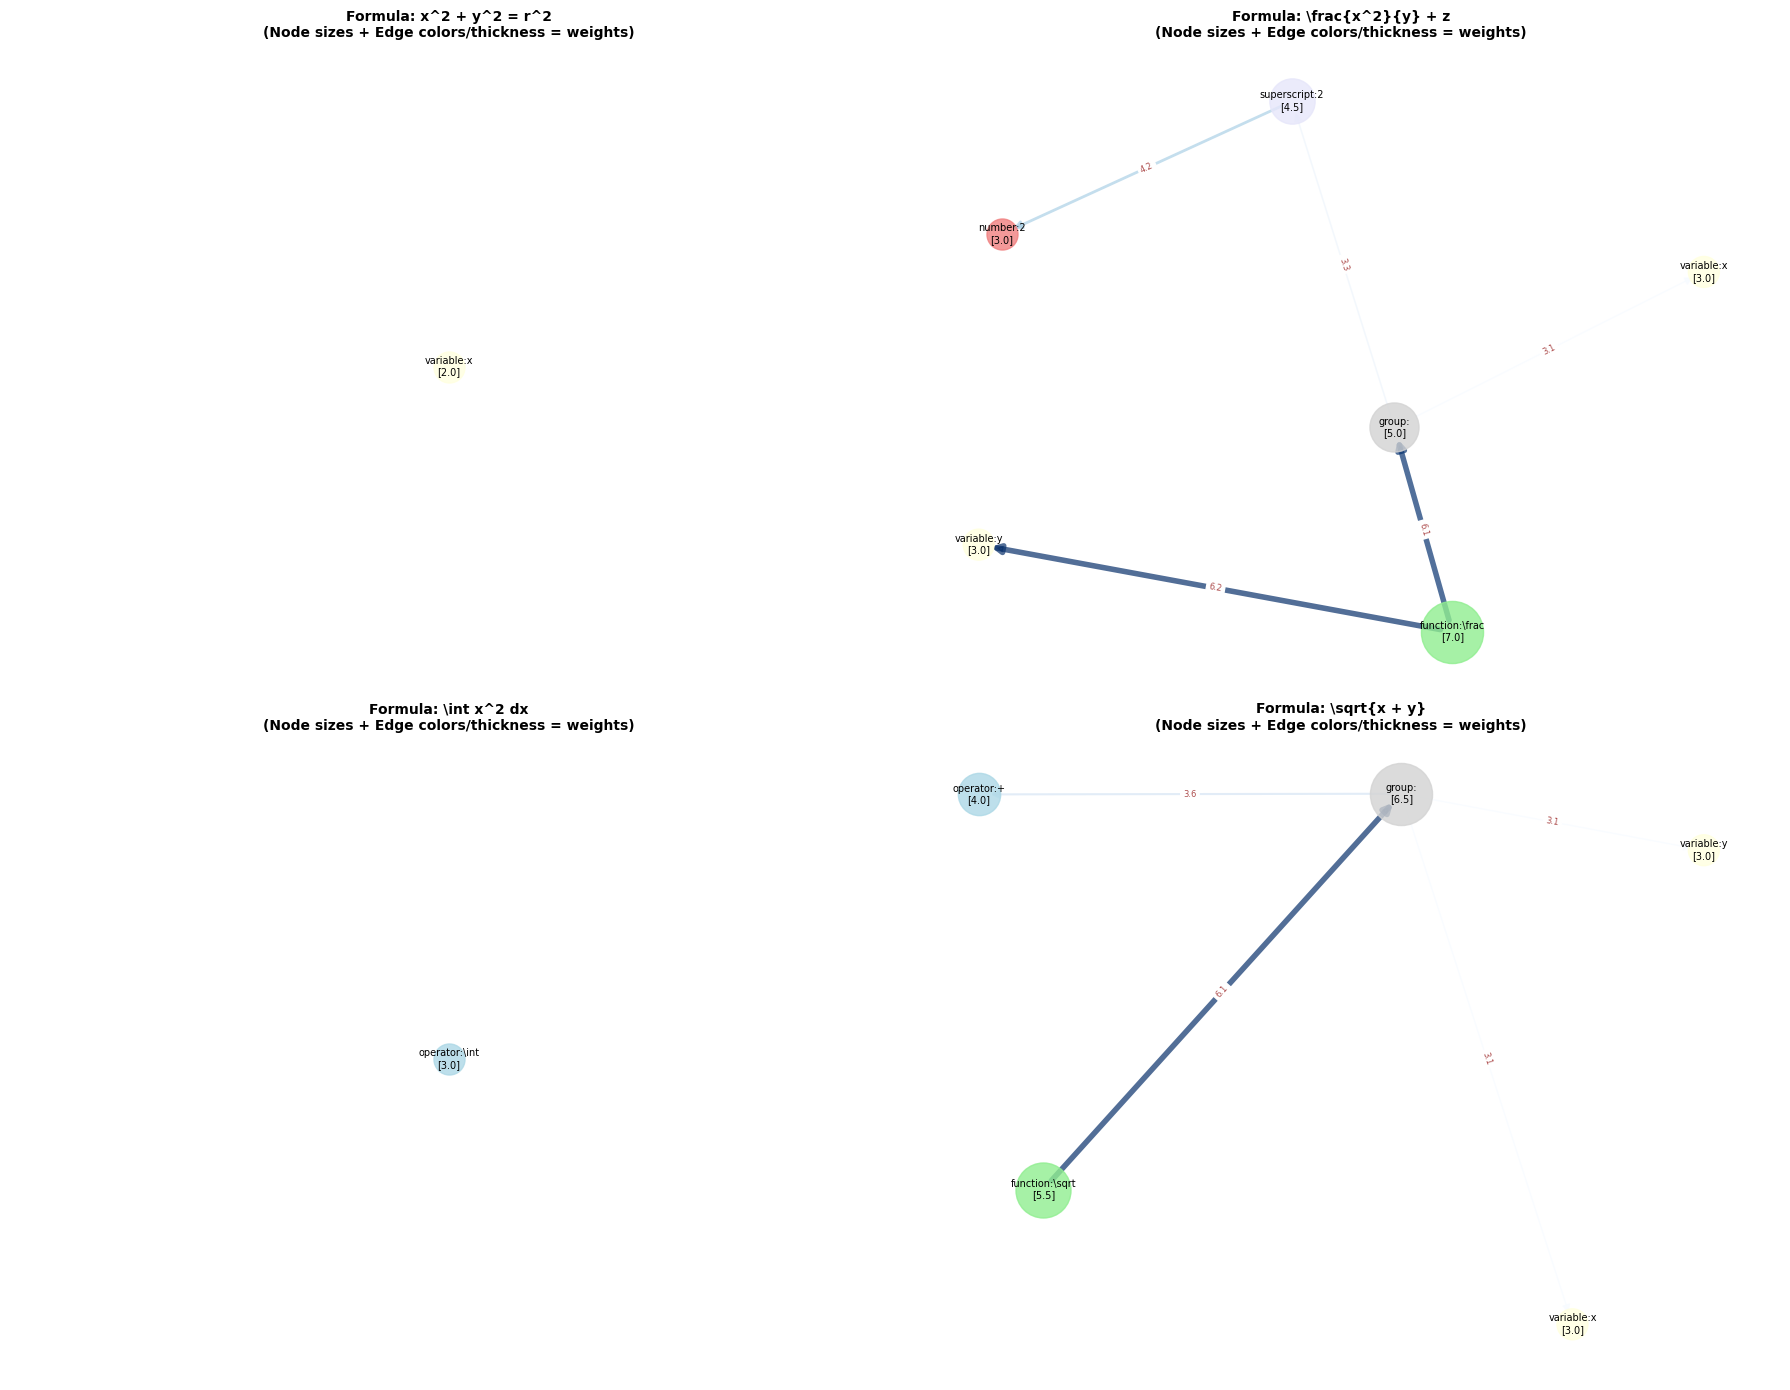

Formula graphs with node and edge weights visualized successfully!

Node Weight Components:
- Base weight: Node type importance (operator=3, function=4, variable=2, etc.)
- Degree weight: Number of connections
- Children weight: Number of child nodes (×0.5)

Edge Weight Components:
- Relationship type: function_arg=5, operator_operand=4, superscript/subscript=3
- Child importance: Based on child node type (×0.5)
- Subtree size: Number of descendants (×0.3, max 5)

Visualization:
- Node size: Proportional to node weight
- Edge thickness: Proportional to edge weight
- Edge color: Blue intensity (darker = higher weight)
- Red numbers: Edge weight values


In [42]:
# Visualize a few formula graphs with node and edge weights
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
axes = axes.flatten()

sample_formulas = [
    "x^2 + y^2 = r^2",
    "\\frac{x^2}{y} + z",
    "\\int x^2 dx",
    "\\sqrt{x + y}"
]

def calculate_node_weights(graph):
    """Calculate node weights based on degree, depth, and node type"""
    weights = {}
    
    # Get depth for each node
    root = [n for n in graph.nodes() if graph.in_degree(n) == 0][0] if len(graph.nodes()) > 0 else None
    
    for node in graph.nodes():
        # Base weight on node type importance
        type_weights = {
            'operator': 3,
            'function': 4,
            'variable': 2,
            'number': 2,
            'symbol': 2,
            'superscript': 2,
            'subscript': 2,
            'group': 1,
            'empty': 1
        }
        
        node_data = graph.nodes[node]
        base_weight = type_weights.get(node_data['type'], 1)
        
        # Add weight based on degree (connectivity)
        degree_weight = graph.degree(node)
        
        # Add weight based on number of children
        children_weight = graph.out_degree(node)
        
        # Combined weight
        weights[node] = base_weight + degree_weight + children_weight * 0.5
    
    return weights

def calculate_edge_weights_inline(graph):
    """Calculate edge weights based on relationship importance"""
    edge_weights = {}
    
    relationship_weights = {
        'function_arg': 5,
        'operator_operand': 4,
        'superscript': 3,
        'subscript': 3,
        'group_member': 2,
        'sequential': 1
    }
    
    node_type_weights = {
        'operator': 3,
        'function': 4,
        'variable': 2,
        'number': 2,
        'symbol': 2,
        'superscript': 2,
        'subscript': 2,
        'group': 1,
        'empty': 1
    }
    
    for u, v in graph.edges():
        parent_data = graph.nodes[u]
        child_data = graph.nodes[v]
        
        # Determine relationship type
        if parent_data['type'] == 'function':
            rel_type = 'function_arg'
        elif parent_data['type'] == 'operator':
            rel_type = 'operator_operand'
        elif parent_data['type'] == 'superscript':
            rel_type = 'superscript'
        elif parent_data['type'] == 'subscript':
            rel_type = 'subscript'
        elif parent_data['type'] == 'group':
            rel_type = 'group_member'
        else:
            rel_type = 'sequential'
        
        base_weight = relationship_weights.get(rel_type, 1)
        child_type_weight = node_type_weights.get(child_data['type'], 1)
        subtree_size = len(list(nx.descendants(graph, v))) + 1
        subtree_weight = min(subtree_size * 0.5, 5)
        
        edge_weights[(u, v)] = base_weight + child_type_weight * 0.5 + subtree_weight * 0.3
    
    return edge_weights

for idx, formula in enumerate(sample_formulas):
    ast = parser.parse(formula)
    fg = FormulaGraph(ast)
    
    plt.sca(axes[idx])
    
    # Calculate node and edge weights
    node_weights = calculate_node_weights(fg.graph)
    edge_weights_map = calculate_edge_weights_inline(fg.graph)
    
    # Normalize weights for visualization
    max_weight = max(node_weights.values()) if node_weights else 1
    min_weight = min(node_weights.values()) if node_weights else 1
    weight_range = max_weight - min_weight if max_weight > min_weight else 1
    
    node_sizes = {n: 500 + (node_weights[n] - min_weight) / weight_range * 1500 
                  for n in node_weights}
    
    # Create graph layout
    pos = nx.spring_layout(fg.graph, k=2, iterations=50)
    
    # Define colors for node types
    node_colors = {
        'operator': 'lightblue',
        'function': 'lightgreen',
        'variable': 'lightyellow',
        'number': 'lightcoral',
        'symbol': 'lightpink',
        'superscript': 'lavender',
        'subscript': 'lavender',
        'group': 'lightgray',
        'empty': 'white'
    }
    
    # Draw nodes with weighted sizes
    for node_type in node_colors:
        nodes = [n for n, d in fg.graph.nodes(data=True) if d['type'] == node_type]
        sizes = [node_sizes[n] for n in nodes]
        nx.draw_networkx_nodes(fg.graph, pos, nodelist=nodes,
                             node_color=node_colors[node_type],
                             node_size=sizes, alpha=0.8)
    
    # Draw edges with edge weights - varying thickness and color
    if edge_weights_map:
        max_edge_weight = max(edge_weights_map.values())
        min_edge_weight = min(edge_weights_map.values())
        edge_weight_range = max_edge_weight - min_edge_weight if max_edge_weight > min_edge_weight else 1
        
        edges_list = list(fg.graph.edges())
        widths = [1 + (edge_weights_map[(u, v)] - min_edge_weight) / edge_weight_range * 3 
                 for u, v in edges_list]
        edge_colors = [(edge_weights_map[(u, v)] - min_edge_weight) / edge_weight_range 
                      for u, v in edges_list]
        
        nx.draw_networkx_edges(fg.graph, pos, edgelist=edges_list,
                              edge_color=edge_colors, edge_cmap=plt.cm.Blues,
                              arrows=True, arrowsize=12, width=widths, 
                              alpha=0.7, edge_vmin=0, edge_vmax=1)
        
        # Add edge labels with weights
        edge_labels = {(u, v): f"{edge_weights_map[(u, v)]:.1f}" 
                     for u, v in edges_list}
        nx.draw_networkx_edge_labels(fg.graph, pos, edge_labels, 
                                    font_size=6, font_color='darkred', alpha=0.7)
    
    # Draw labels with weight annotations
    labels = {}
    for n, d in fg.graph.nodes(data=True):
        weight_str = f"[{node_weights[n]:.1f}]"
        labels[n] = f"{d['label']}\n{weight_str}"
    
    nx.draw_networkx_labels(fg.graph, pos, labels, font_size=7)
    
    axes[idx].set_title(f"Formula: {formula}\n(Node sizes + Edge colors/thickness = weights)", 
                       fontsize=10, fontweight='bold')
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

print("Formula graphs with node and edge weights visualized successfully!")
print("\nNode Weight Components:")
print("- Base weight: Node type importance (operator=3, function=4, variable=2, etc.)")
print("- Degree weight: Number of connections")
print("- Children weight: Number of child nodes (×0.5)")
print("\nEdge Weight Components:")
print("- Relationship type: function_arg=5, operator_operand=4, superscript/subscript=3")
print("- Child importance: Based on child node type (×0.5)")
print("- Subtree size: Number of descendants (×0.3, max 5)")
print("\nVisualization:")
print("- Node size: Proportional to node weight")
print("- Edge thickness: Proportional to edge weight")
print("- Edge color: Blue intensity (darker = higher weight)")
print("- Red numbers: Edge weight values")

Testing weighted visualization on the FormulaGraph class:

Formula: \frac{x^2 + y^2}{\sqrt{z}}
Calculating node weights...

Node weights:
  Node 1 (variable:x): weight = 3.00
  Node 2 (number:2): weight = 3.00
  Node 3 (superscript:2): weight = 4.50
  Node 4 (operator:+): weight = 4.00
  Node 5 (variable:y): weight = 3.00
  Node 6 (number:2): weight = 3.00
  Node 7 (superscript:2): weight = 4.50
  Node 8 (group:): weight = 9.50
  Node 9 (variable:z): weight = 3.00
  Node 10 (function:\sqrt): weight = 6.50
  Node 11 (function:\frac): weight = 7.00


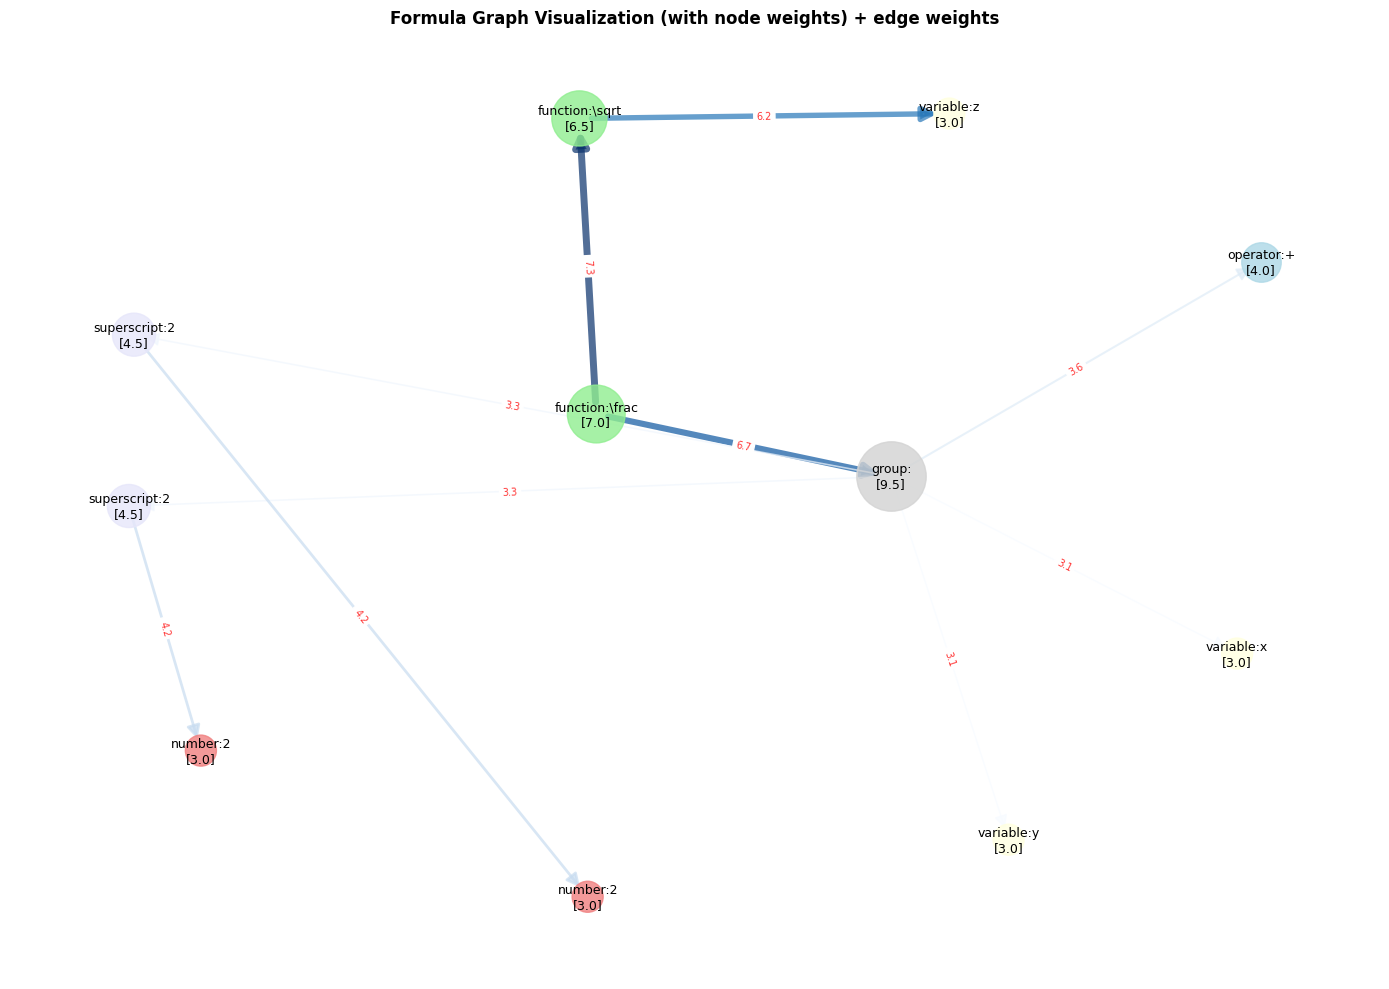

In [43]:
# Test the updated visualize method with weights
print("Testing weighted visualization on the FormulaGraph class:")
formula = "\\frac{x^2 + y^2}{\\sqrt{z}}"
ast = parser.parse(formula)
fg = FormulaGraph(ast)

print(f"\nFormula: {formula}")
print(f"Calculating node weights...")
weights = fg.calculate_node_weights()
print("\nNode weights:")
for node_id, weight in sorted(weights.items()):
    node_data = fg.graph.nodes[node_id]
    print(f"  Node {node_id} ({node_data['label']}): weight = {weight:.2f}")

# Visualize with weights
fg.visualize(figsize=(14, 10), show_weights=True)
plt.show()

Testing Edge Weights Visualization

Formula: \frac{x^2 + y^2}{\sqrt{z^3}}

Calculating edge weights...

Edge weights (showing relationship importance):
  function:\frac -> function:\sqrt: 7.75
  function:\frac -> group:: 6.70
  function:\sqrt -> group:: 6.10
  superscript:2 -> number:2: 4.15
  superscript:2 -> number:2: 4.15
  superscript:3 -> number:3: 4.15
  group: -> operator:+: 3.65
  group: -> superscript:2: 3.30
  group: -> superscript:2: 3.30
  group: -> superscript:3: 3.30
  group: -> variable:x: 3.15
  group: -> variable:y: 3.15
  group: -> variable:z: 3.15

Generating visualization with edge weights...


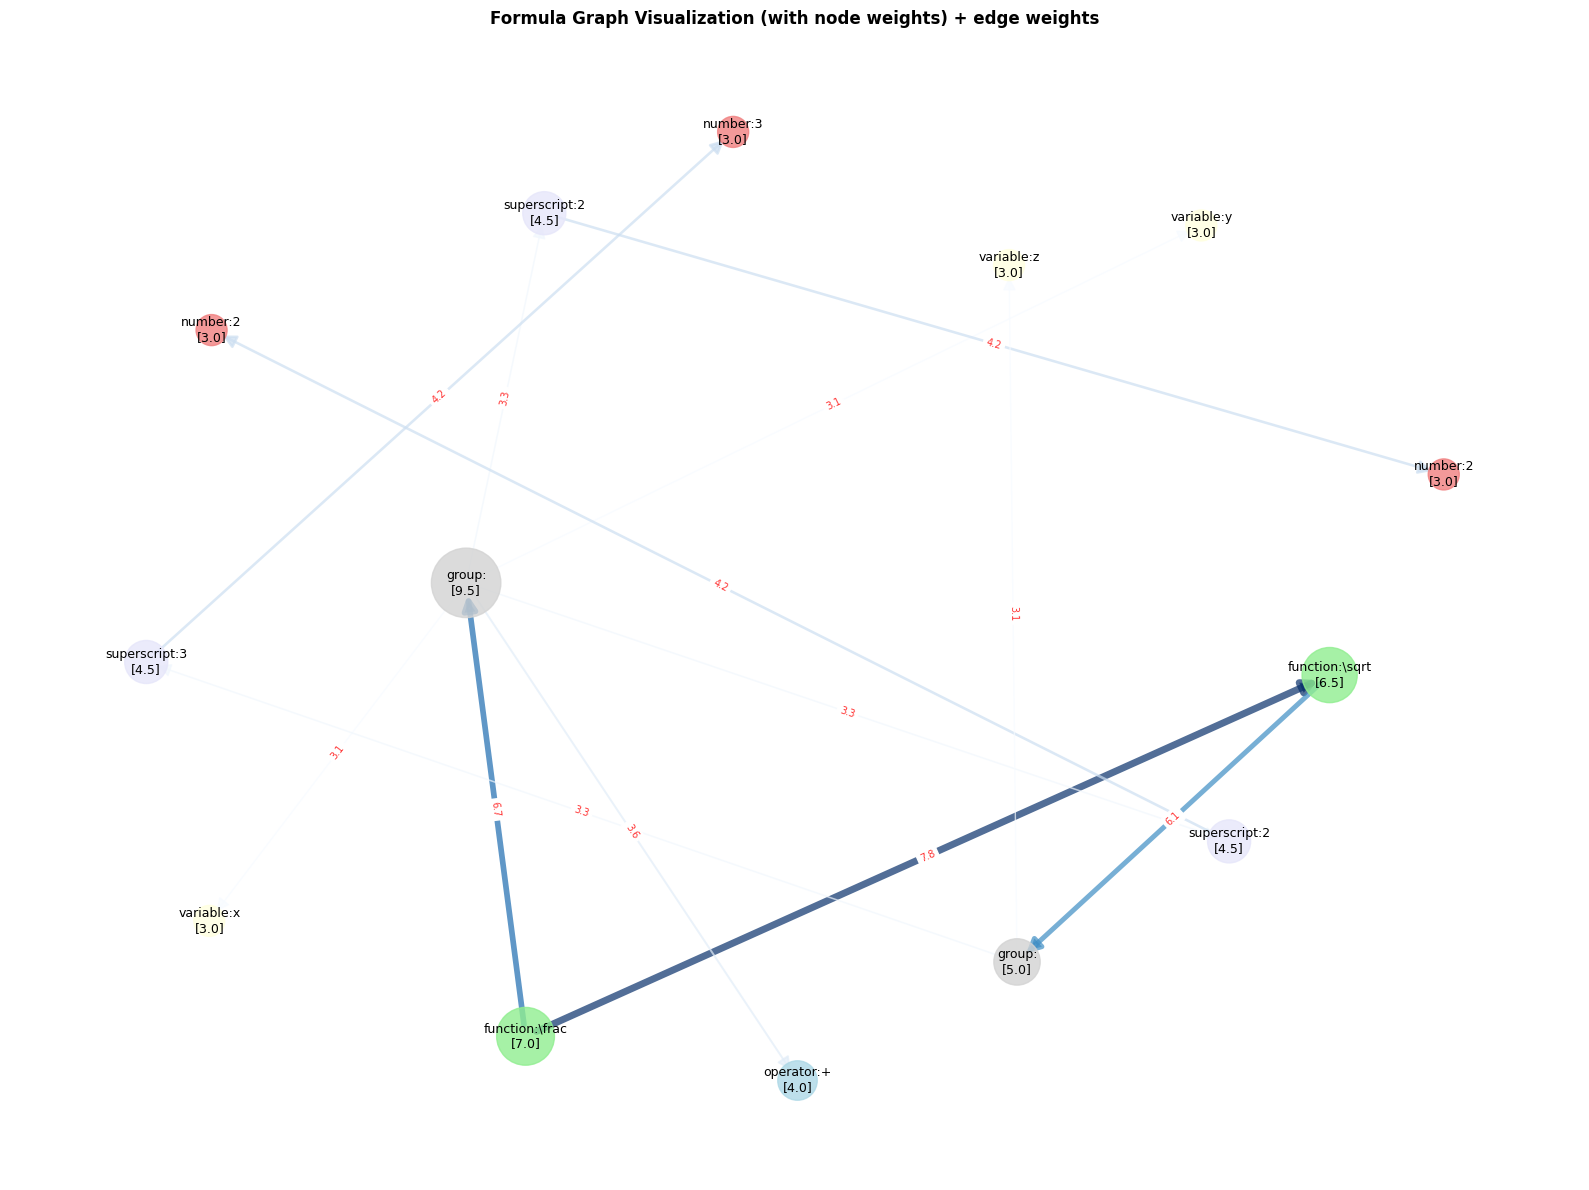


Edge Weight Components:
- Relationship type: function_arg=5, operator_operand=4, superscript=3, subscript=3, etc.
- Child node importance: Based on node type (×0.5)
- Subtree size: Size of subtree rooted at child node (×0.3, capped at 5)
- Edge color: Blue intensity represents weight (darker = heavier)
- Edge thickness: Proportional to weight
- Red labels: Show numerical edge weight values


In [44]:
# Test edge weights visualization
print("Testing Edge Weights Visualization")
print("=" * 60)

formula = "\\frac{x^2 + y^2}{\\sqrt{z^3}}"
ast = parser.parse(formula)
fg = FormulaGraph(ast)

print(f"\nFormula: {formula}")
print(f"\nCalculating edge weights...")
edge_weights = fg.calculate_edge_weights()

print(f"\nEdge weights (showing relationship importance):")
for (u, v), weight in sorted(edge_weights.items(), key=lambda x: x[1], reverse=True):
    parent_data = fg.graph.nodes[u]
    child_data = fg.graph.nodes[v]
    print(f"  {parent_data['label']} -> {child_data['label']}: {weight:.2f}")

# Visualize with both node and edge weights
print("\nGenerating visualization with edge weights...")
fg.visualize(figsize=(16, 12), show_weights=True, show_edge_weights=True)
plt.show()

print("\nEdge Weight Components:")
print("- Relationship type: function_arg=5, operator_operand=4, superscript=3, subscript=3, etc.")
print("- Child node importance: Based on node type (×0.5)")
print("- Subtree size: Size of subtree rooted at child node (×0.3, capped at 5)")
print("- Edge color: Blue intensity represents weight (darker = heavier)")
print("- Edge thickness: Proportional to weight")
print("- Red labels: Show numerical edge weight values")

## 8. Persistence: Save and Load Index

Implement serialization for the formula index.

In [45]:
import pickle

class PersistentFormulaIndex(FormulaIndex):
    """Formula index with save/load capabilities"""
    
    def save(self, filepath: str):
        """Save index to file"""
        data = {
            'formulas': {},
            'symbol_index': dict(self.symbol_index),
            'operator_index': dict(self.operator_index),
            'structure_index': dict(self.structure_index),
            'next_id': self.next_id
        }
        
        # Save formulas (excluding graph objects which need special handling)
        for fid, fdata in self.formulas.items():
            data['formulas'][fid] = {
                'latex': fdata['latex'],
                'metadata': fdata['metadata']
            }
        
        with open(filepath, 'wb') as f:
            pickle.dump(data, f)
        
        print(f"Index saved to {filepath}")
    
    def load(self, filepath: str):
        """Load index from file"""
        with open(filepath, 'rb') as f:
            data = pickle.load(f)
        
        # Restore data
        self.next_id = data['next_id']
        self.symbol_index = defaultdict(set, {k: set(v) for k, v in data['symbol_index'].items()})
        self.operator_index = defaultdict(set, {k: set(v) for k, v in data['operator_index'].items()})
        self.structure_index = defaultdict(set, {k: set(v) for k, v in data['structure_index'].items()})
        
        # Rebuild formulas with graphs
        self.formulas = {}
        for fid, fdata in data['formulas'].items():
            latex = fdata['latex']
            ast = parser.parse(latex)
            fg = FormulaGraph(ast)
            
            self.formulas[fid] = {
                'latex': latex,
                'ast': ast,
                'graph': fg,
                'metadata': fdata['metadata']
            }
        
        print(f"Index loaded from {filepath}")
        print(f"Statistics: {self.get_statistics()}")
    
    def export_to_json(self, filepath: str):
        """Export index to JSON format (for inspection)"""
        data = {
            'formulas': {
                fid: {
                    'latex': fdata['latex'],
                    'metadata': fdata['metadata'],
                    'graph_nodes': len(fdata['graph'].graph.nodes()),
                    'graph_edges': len(fdata['graph'].graph.edges())
                }
                for fid, fdata in self.formulas.items()
            },
            'statistics': self.get_statistics()
        }
        
        with open(filepath, 'w') as f:
            json.dump(data, f, indent=2)
        
        print(f"Index exported to {filepath}")


# Test persistence
persistent_index = PersistentFormulaIndex()

# Add formulas
for formula in test_formulas:
    persistent_index.add_formula(formula, metadata={'source': 'test'})

# Save index
persistent_index.save('formula_index.pkl')

# Export to JSON
persistent_index.export_to_json('formula_index.json')

# Create new index and load
loaded_index = PersistentFormulaIndex()
loaded_index.load('formula_index.pkl')

# Verify loaded index works
print("\n" + "=" * 60)
print("Testing loaded index:")
results = loaded_index.search_by_symbol('x')
print(f"Formulas with 'x': {len(results)}")
for fid in sorted(list(results)[:5]):
    print(f"  [{fid}] {loaded_index.get_formula(fid)['latex']}")

Index saved to formula_index.pkl
Index exported to formula_index.json
Index loaded from formula_index.pkl
Statistics: {'total_formulas': 10, 'unique_symbols': 6, 'unique_operators': 5, 'unique_structures': 19}

Testing loaded index:
Formulas with 'x': 3
  [0] x^2 + y^2 = r^2
  [2] \frac{x^2}{y} + z
  [8] \sqrt{x^2 + y^2}


## 9. Complete Search Interface

Create a unified search interface with all search methods.

In [46]:
class FormulaSearchEngine:
    """Unified search interface for LaTeX formulas"""
    
    def __init__(self):
        self.index = PersistentFormulaIndex()
    
    def add_formula(self, latex: str, metadata: Optional[Dict] = None) -> int:
        """Add formula to search engine"""
        return self.index.add_formula(latex, metadata)
    
    def add_formulas_batch(self, formulas: List[Tuple[str, Optional[Dict]]]):
        """Add multiple formulas"""
        results = []
        for latex, metadata in formulas:
            fid = self.add_formula(latex, metadata)
            results.append(fid)
        return results
    
    def search(self, query: str, method: str = 'auto', **kwargs) -> List[Tuple[int, Dict]]:
        """
        Universal search method
        
        Args:
            query: LaTeX formula or search query
            method: Search method - 'exact', 'pattern', 'similarity', 'fuzzy', 'auto'
            **kwargs: Additional parameters for specific methods
        
        Returns:
            List of (formula_id, result_info) tuples
        """
        if method == 'exact':
            return self._search_exact(query)
        elif method == 'pattern':
            return self._search_pattern(query, **kwargs)
        elif method == 'similarity':
            return self._search_similarity(query, **kwargs)
        elif method == 'fuzzy':
            return self._search_fuzzy(query, **kwargs)
        elif method == 'auto':
            return self._search_auto(query, **kwargs)
        else:
            raise ValueError(f"Unknown search method: {method}")
    
    def _search_exact(self, query: str) -> List[Tuple[int, Dict]]:
        """Exact match search"""
        results = []
        for fid, fdata in self.index.formulas.items():
            if fdata['latex'] == query:
                results.append((fid, {
                    'latex': fdata['latex'],
                    'match_type': 'exact',
                    'score': 1.0
                }))
        return results
    
    def _search_pattern(self, query: str, **kwargs) -> List[Tuple[int, Dict]]:
        """Pattern-based search (subgraph matching)"""
        matches = SubgraphMatcher.match_pattern(query, self.index)
        results = []
        for fid, mappings in matches:
            fdata = self.index.get_formula(fid)
            results.append((fid, {
                'latex': fdata['latex'],
                'match_type': 'pattern',
                'num_matches': len(mappings),
                'score': 1.0
            }))
        return results
    
    def _search_similarity(self, query: str, top_k: int = 10) -> List[Tuple[int, Dict]]:
        """Similarity-based search"""
        similar = SimilaritySearch.find_similar_by_features(query, self.index, top_k=top_k)
        results = []
        for fid, score in similar:
            fdata = self.index.get_formula(fid)
            results.append((fid, {
                'latex': fdata['latex'],
                'match_type': 'similarity',
                'score': score
            }))
        return results
    
    def _search_fuzzy(self, query: str, **kwargs) -> List[Tuple[int, Dict]]:
        """Fuzzy pattern matching"""
        ignore_values = kwargs.get('ignore_values', False)
        matches = SubgraphMatcher.match_fuzzy_pattern(query, self.index, ignore_values)
        results = []
        for fid, score, mappings in matches:
            fdata = self.index.get_formula(fid)
            results.append((fid, {
                'latex': fdata['latex'],
                'match_type': 'fuzzy',
                'score': score
            }))
        return results
    
    def _search_auto(self, query: str, **kwargs) -> List[Tuple[int, Dict]]:
        """Automatic search - try multiple methods"""
        # Try exact first
        exact_results = self._search_exact(query)
        if exact_results:
            return exact_results
        
        # Try pattern matching
        pattern_results = self._search_pattern(query)
        if pattern_results:
            return pattern_results
        
        # Fall back to similarity
        top_k = kwargs.get('top_k', 10)
        return self._search_similarity(query, top_k=top_k)
    
    def search_by_components(self, symbols: Optional[List[str]] = None,
                           operators: Optional[List[str]] = None,
                           structure: Optional[str] = None) -> List[Tuple[int, Dict]]:
        """Search by formula components"""
        formula_ids = self.index.search_combined(symbols, operators, structure)
        results = []
        for fid in formula_ids:
            fdata = self.index.get_formula(fid)
            results.append((fid, {
                'latex': fdata['latex'],
                'match_type': 'component',
                'score': 1.0
            }))
        return results
    
    def get_formula_details(self, formula_id: int) -> Optional[Dict]:
        """Get detailed information about a formula"""
        fdata = self.index.get_formula(formula_id)
        if not fdata:
            return None
        
        return {
            'id': formula_id,
            'latex': fdata['latex'],
            'metadata': fdata['metadata'],
            'graph_info': {
                'nodes': fdata['graph'].graph.number_of_nodes(),
                'edges': fdata['graph'].graph.number_of_edges()
            }
        }
    
    def save(self, filepath: str):
        """Save search engine index"""
        self.index.save(filepath)
    
    def load(self, filepath: str):
        """Load search engine index"""
        self.index.load(filepath)
    
    def get_statistics(self) -> Dict:
        """Get search engine statistics"""
        return self.index.get_statistics()


# Test the complete search engine
print("=" * 60)
print("Complete Formula Search Engine Test")
print("=" * 60)

engine = FormulaSearchEngine()

# Add test formulas
test_data = [
    ("x^2 + y^2 = r^2", {'name': 'circle equation'}),
    ("a^2 + b^2 = c^2", {'name': 'Pythagorean theorem'}),
    ("E = mc^2", {'name': 'mass-energy equivalence'}),
    ("F = ma", {'name': 'Newton second law'}),
    ("\\frac{-b \\pm \\sqrt{b^2 - 4ac}}{2a}", {'name': 'quadratic formula'}),
    ("\\int_a^b f(x) dx", {'name': 'definite integral'}),
    ("\\sum_{i=1}^n i = \\frac{n(n+1)}{2}", {'name': 'sum formula'}),
]

for latex, metadata in test_data:
    fid = engine.add_formula(latex, metadata)
    print(f"Added [{fid}]: {latex}")

print(f"\nEngine statistics: {engine.get_statistics()}")

# Test different search methods
print("\n" + "=" * 60)
print("Search Test 1: Exact match")
results = engine.search("E = mc^2", method='exact')
print(f"Results: {len(results)}")
for fid, info in results:
    print(f"  [{fid}] {info['latex']} (score: {info['score']:.3f})")

print("\n" + "=" * 60)
print("Search Test 2: Similarity search for 'x^2 + y^2'")
results = engine.search("x^2 + y^2", method='similarity', top_k=3)
print(f"Top 3 results:")
for fid, info in results:
    print(f"  [{fid}] {info['latex']} (score: {info['score']:.3f})")

print("\n" + "=" * 60)
print("Search Test 3: Component search - formulas with 'x' and '^'")
results = engine.search_by_components(symbols=['x'], operators=['^'])
print(f"Results: {len(results)}")
for fid, info in results[:5]:
    print(f"  [{fid}] {info['latex']}")

print("\n" + "=" * 60)
print("Search Test 4: Auto search for 'a^2 + b^2'")
results = engine.search("a^2 + b^2", method='auto')
print(f"Results: {len(results)}")
for fid, info in results[:5]:
    print(f"  [{fid}] {info['latex']} ({info['match_type']}, score: {info['score']:.3f})")

Complete Formula Search Engine Test
Added [0]: x^2 + y^2 = r^2
Added [1]: a^2 + b^2 = c^2
Added [2]: E = mc^2
Added [3]: F = ma
Added [4]: \frac{-b \pm \sqrt{b^2 - 4ac}}{2a}
Added [5]: \int_a^b f(x) dx
Added [6]: \sum_{i=1}^n i = \frac{n(n+1)}{2}

Engine statistics: {'total_formulas': 7, 'unique_symbols': 7, 'unique_operators': 5, 'unique_structures': 14}

Search Test 1: Exact match
Results: 1
  [2] E = mc^2 (score: 1.000)

Search Test 2: Similarity search for 'x^2 + y^2'
Top 3 results:
  [0] x^2 + y^2 = r^2 (score: 1.000)
  [1] a^2 + b^2 = c^2 (score: 1.000)
  [2] E = mc^2 (score: 1.000)

Search Test 3: Component search - formulas with 'x' and '^'
Results: 0

Search Test 4: Auto search for 'a^2 + b^2'
Results: 2
  [1] a^2 + b^2 = c^2 (pattern, score: 1.000)
  [4] \frac{-b \pm \sqrt{b^2 - 4ac}}{2a} (pattern, score: 1.000)


## 10. Summary and Usage Examples

Summary of the graph-based LaTeX formula search and index system.

### Key Features Implemented:

1. **LaTeX Parser**: Converts LaTeX formulas to Abstract Syntax Trees (AST)
2. **Graph Representation**: Transforms ASTs into directed graphs using NetworkX
3. **Inverted Index**: Multiple indexes for efficient lookup:
   - Symbol index (variables, constants)
   - Operator index (functions, operators)
   - Structure index (graph patterns)
4. **Search Algorithms**:
   - Exact match search
   - Symbol/operator-based search
   - Structural similarity search
   - Subgraph pattern matching
   - Fuzzy matching
   - Feature-based similarity (cosine similarity)
   - Graph edit distance
5. **Persistence**: Save/load index to disk
6. **Visualization**: Graph visualization of formulas

### Usage Examples:

```python
# Initialize search engine
engine = FormulaSearchEngine()

# Add formulas
engine.add_formula("x^2 + y^2 = r^2", metadata={'source': 'geometry'})
engine.add_formula("E = mc^2", metadata={'source': 'physics'})

# Search by exact match
results = engine.search("E = mc^2", method='exact')

# Search by similarity
results = engine.search("x^2 + y^2", method='similarity', top_k=5)

# Search by components
results = engine.search_by_components(symbols=['x', 'y'], operators=['^'])

# Auto search (tries multiple methods)
results = engine.search("a^2 + b^2", method='auto')

# Save index
engine.save('my_formula_index.pkl')

# Load index
engine.load('my_formula_index.pkl')
```

### Performance Characteristics:

- **Indexing**: O(n × m) where n = number of formulas, m = average formula size
- **Symbol/Operator Search**: O(1) lookup + O(k) result iteration
- **Structure Search**: O(s × n) where s = number of structural patterns
- **Subgraph Matching**: O(n × g) where g = graph matching complexity (exponential in worst case)
- **Similarity Search**: O(n × f) where f = feature comparison time

### Applications:

1. Mathematical document search
2. Formula recommendation systems
3. Duplicate formula detection
4. LaTeX autocomplete
5. Educational tools (finding similar problems)
6. Research paper indexing